In [1]:
# https://towardsdatascience.com/hands-on-generative-adversarial-networks-gan-for-signal-processing-with-python-ff5b8d78bd28

In [1]:
import pickle
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [2]:
%run ./read_file.ipynb

:: loading settings :: url = jar:file:/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ec2-user/.ivy2/cache
The jars for the packages stored in: /home/ec2-user/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ddc9f869-0b62-415f-9fa6-48c67825b2f6;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 148ms :: artifacts dl 5ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-----------------------------

23/04/17 05:35:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/17 05:35:32 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# https://stackoverflow.com/questions/68036975/valueerror-shape-must-be-at-least-rank-3-but-is-rank-2-for-node-biasadd
# config for rank error in lstm
tf.keras.backend.set_image_data_format("channels_last")

pd.set_option('display.max_columns', None)

In [4]:
ds = spark.read.parquet(*["s3a://sapient-bucket-trusted/prod/graph/encoded/real/23Sep3/*"]) \
                .withColumn("event_sequence",col('event_sequence').cast('string')) \
                .cache()

In [5]:
tot = ds.count()

In [6]:
ds.groupBy("mal_trace") \
    .count() \
    .withColumnRenamed('count', 'cnt_per_group') \
    .withColumn('perc_of_count_total', (col('cnt_per_group') / tot) * 100 ) \
    .sort("perc_of_count_total").show()

+---------+-------------+-------------------+
|mal_trace|cnt_per_group|perc_of_count_total|
+---------+-------------+-------------------+
|        1|       118763| 0.6835843967111419|
|        0|     17254805|  99.31641560328886|
+---------+-------------+-------------------+



In [7]:
# Set Config
max_length = 6
sequence_length = 6
max_features = 6
padding_type = 'post'
trunc_type = 'post'
input_len = 10000

# place to save model after
ckt_path_generator = 'saved_model/generator'
ckt_path_tokenizer = 'saved_model/tokenizer'

In [8]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)

In [9]:
ds_events = ds.select('event_sequence').rdd.flatMap(lambda x: x).collect()

In [10]:
# get vocab for full dataset 
tokenizer.fit_on_texts(ds_events)
# Get our training data word index
word_index = tokenizer.word_index
vocab_count = len(word_index)

In [11]:
# save tokenizer for reuse
with open(ckt_path_tokenizer, 'wb') as f:
    pickle.dump(tokenizer, f)

In [12]:
# seq_enc_tensor.shape
# # shape - (input_len, sequence_length, vocab_size)
# input_len = seq_enc_tensor.shape[0]
# sequence_length = seq_enc_tensor.shape[1]

In [13]:
def define_generator():
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(sequence_length, vocab_count)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_count, activation='linear')),
    tf.keras.layers.LeakyReLU(),
    ])

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

def define_discriminator():
    model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(sequence_length, vocab_count)),
            tf.keras.layers.LSTM(128, return_sequences=False),
            tf.keras.layers.Dense(2, activation='linear'),
            tf.keras.layers.LeakyReLU(),
    ])

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

    return model

def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    
    return model

def generate_latent_space():
    n = tf.random.uniform(shape=[input_len, sequence_length, vocab_count], minval=1, maxval=vocab_count, dtype=tf.int32)
    return n

def generate_fake_samples(generator):
    # generate points in latent space & pass through generator
    x = generator.predict(generate_latent_space(), verbose=0)
    # create class labels
    y = zeros((input_len,1))
    return x, y

# def generate_real_samples():
#     x = seq_enc_tensor
#     # create class labels
#     y = ones((input_len,1))
#     return x, y

def generate_real_samples():
    # each time, this should produce a different sample of the larger data
    # get only malicious data
    ds_mal = ds.filter( col('mal_trace') == 1).cache()

    # now randomly sample from the malicious data
    n = input_len  # number of rows to select
    total_rows = ds_mal.count()
    fraction = float(n) / float(total_rows)
    df_sample, _ = ds_mal.randomSplit([fraction, 1.0 - fraction], seed=42)
    df_sample = df_sample.limit(n)

    ds.unpersist()
    dm_events = df_sample.select('event_sequence').rdd.flatMap(lambda x: x).collect()
    dm_labels = df_sample.select('mal_trace').rdd.flatMap(lambda x: x).collect()
    # one hot encode the data
    dm_sequences = tokenizer.texts_to_sequences(dm_events)
    dm_padded = tf.keras.utils.pad_sequences(dm_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    seq_enc_tensor = tf.one_hot(dm_padded, vocab_count)
    x = seq_enc_tensor
    # create class labels
    y = ones((input_len,1))
    return x, y

def make_samples(g_model):
    x_gen, y_gen = generate_fake_samples(g_model)
    new_seq_enc = tf.argmax(x_gen, axis=-1)
    new_seq_texts = tokenizer.sequences_to_texts(new_seq_enc.numpy())
    gen_events = [[','.join(n.split())] for n in new_seq_texts]
    gen_labels = [1]*input_len
    trace_list = [99999]*input_len
    d_gen = list(zip(trace_list, gen_labels, gen_labels, gen_events))
    df_gen = spark.createDataFrame(d_gen, ['Trace', 'mal_trace', 'malicious', 'event_sequence'])
    return df_gen

def train(g_model, d_model, gan_model, epochs=5, n_eval=50):
    d_acc_history = []
    d_loss_history = []
    g_acc_history = []
    g_loss_history = []
    sample_count_history = []

    d_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    g_metric = tf.keras.metrics.CategoricalAccuracy()

    # manually enumerate epochs
    for i in range(epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples()
        # prepare fake examples using the generator
        x_fake, y_fake = generate_fake_samples(g_model)

        # update discriminator
        d_real_loss = d_model.train_on_batch(x_real, y_real)
        d_fake_loss = d_model.train_on_batch(x_fake, y_fake)
        d_loss = 0.5 * (d_real_loss + d_fake_loss)

        d_real_pred = d_model.predict_on_batch(x_real)
        d_fake_pred = d_model.predict_on_batch(x_fake)

        d_metric.update_state(tf.concat([y_real, y_fake], axis=0), tf.concat([d_real_pred, d_fake_pred], axis=0))
        d_acc = d_metric.result().numpy()

        # prepare points in latent space as input for the generator
        x_gan = generate_latent_space()
        y_gan = ones((input_len, 1))
        g_loss = gan_model.train_on_batch(x_gan, y_gan)

        # update the generator via the discriminator's error
        gan_pred = gan_model.predict_on_batch(x_gan)
        g_metric.update_state(tf.one_hot(tf.cast(y_gan, tf.int32), depth=2), gan_pred)
        g_acc = g_metric.result().numpy()

        d_acc_history.append(d_acc)
        d_loss_history.append(d_loss)
        g_acc_history.append(g_acc)
        g_loss_history.append(g_loss)

        if i % n_eval == 0:
            gen = make_samples(g_model)
            dc_seq = gen.groupBy("mal_trace").agg(countDistinct('event_sequence')).select('count(event_sequence)').collect()[0]['count(event_sequence)']
            seq_len = len(gen.limit(1).select('event_sequence').collect()[0]['event_sequence'][0])
            sample_count_history.append(dc_seq)
            if i % 100 == 0:
                print(f"The total number of distinct generated samples is: {dc_seq} and had a sequence that has a length {seq_len}")
                print(f"Epoch {i}: Discriminator Loss: {d_loss}, Discriminator Accuracy: {d_acc}, Generator Loss: {g_loss}, Generator Accuracy: {g_acc}")
    # checkpoint model after completion of epochs
    g_model.save(ckt_path_generator)

    return d_acc_history, d_loss_history, g_acc_history, g_loss_history, sample_count_history

In [15]:
generator = define_generator()
discriminator = define_discriminator()
gan = define_gan(generator, discriminator)

In [16]:
epochs = 200
eval_step = 10
d_acc_history, d_loss_history, g_acc_history, g_loss_history, sample_count_history = train(generator, discriminator, gan, epochs=epochs, n_eval=eval_step)

The total number of distinct generated samples is: 69 and had a sequence that has a length 0
Epoch 0: Discriminator Loss: 8.176985502243042, Discriminator Accuracy: 0.6459000110626221, Generator Loss: 0.6974653601646423, Generator Accuracy: 0.9821000099182129
The total number of distinct generated samples is: 14 and had a sequence that has a length 251
Epoch 100: Discriminator Loss: 0.6931471824645996, Discriminator Accuracy: 0.8683505058288574, Generator Loss: 0.6931471824645996, Generator Accuracy: 0.2917247414588928


INFO:tensorflow:Assets written to: saved_model/generator/assets


INFO:tensorflow:Assets written to: saved_model/generator/assets


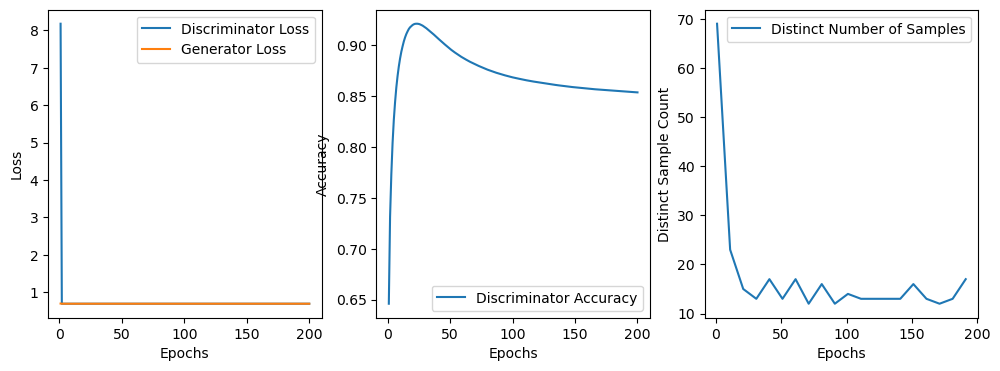

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.plot(range(1, epochs + 1), d_loss_history, label='Discriminator Loss')
ax1.plot(range(1, epochs + 1), g_loss_history, label='Generator Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(range(1, epochs + 1), d_acc_history, label='Discriminator Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

ax3.plot(range(1, epochs + 1, eval_step), sample_count_history, label='Distinct Number of Samples')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Distinct Sample Count')
ax3.legend()

plt.show()

In [14]:
# Create a basic model instance
generator = define_generator()
generator.load_weights(ckt_path_generator)

In [15]:
def make_samples(generator):
    x_gen, y_gen = generate_fake_samples(generator)
    new_seq_enc = tf.argmax(x_gen, axis=-1)
    new_seq_texts = tokenizer.sequences_to_texts(new_seq_enc.numpy())
    gen_events = [[','.join(n.split())] for n in new_seq_texts]
    gen_labels = [1]*input_len
    trace_list = [99999]*input_len
    d_gen = list(zip(trace_list, gen_labels, gen_labels, gen_events))
    df_gen = spark.createDataFrame(d_gen, ['Trace', 'mal_trace', 'malicious', 'event_sequence'])
    return df_gen

In [16]:
# Define the number of iterations
num_iterations = 50

#initialize combined dataframe
gen_samp = None

In [17]:
# Loop over the input parameters
for param in range(num_iterations):
    # Create a dataframe with the current input parameter
    df = make_samples(generator)
    # filter out rows where there is no data
    # Append the dataframe to the combined dataframe using union
    if gen_samp is None:
        gen_samp = df
    else:
        gen_samp = gen_samp.union(df) 

In [18]:
# drop the first row
w = Window.orderBy("event_sequence")

In [19]:
gen_dist = gen_samp.select(*gen_samp.columns).distinct().sort( col('event_sequence').asc())
gen_dist = gen_dist.withColumn("row_num", row_number().over(w)).filter("row_num != 1").drop("row_num").cache()
gen_dist.count()

54

In [20]:
gen_dist.show(5)

+-----+---------+---------+--------------------+
|Trace|mal_trace|malicious|      event_sequence|
+-----+---------+---------+--------------------+
|99999|        1|        1|[1000000000010000...|
|99999|        1|        1|[1000000000010000...|
|99999|        1|        1|[1000000000010000...|
|99999|        1|        1|[1000000000010000...|
|99999|        1|        1|[1000000000010000...|
+-----+---------+---------+--------------------+
only showing top 5 rows



In [21]:
gen_dist.limit(5).toPandas()

,Trace,mal_trace,malicious,event_sequence
0,99999,1,1,[10000000000100001000100001000000000000010]
1,99999,1,1,"[10000000000100001000100001000000000000010,100..."
2,99999,1,1,"[10000000000100001000100001000000000000010,100..."
3,99999,1,1,"[10000000000100001000100001000000000000010,100..."
4,99999,1,1,[10000000000100001000100001000000000001000]


In [22]:
dc_gen_seq = gen_dist.groupBy("mal_trace").agg(countDistinct('event_sequence')).select('count(event_sequence)').collect()[0]['count(event_sequence)']
print(f"The total number of distinct generated samples is: {dc_gen_seq}")

The total number of distinct generated samples is: 54


In [ ]:
gen_dist.write.option("maxRecordsPerFile", 300000).mode("overwrite").parquet("s3a://sapient-bucket-trusted/prod/graph/motifs/gen_malicious/")
n = 499
for i in range(n):
    gen_dist.write.option("maxRecordsPerFile", 300000).mode("append").parquet("s3a://sapient-bucket-trusted/prod/graph/motifs/gen_malicious/")

In [ ]:
dt = spark.read.parquet(*["s3a://sapient-bucket-trusted/prod/graph/motifs/gen_malicious/*"]) \
                .cache()

In [ ]:
dt.count()

27000